In [32]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
# from tensorflow import keras
# from tensorflow.keras import layers
warnings.filterwarnings(action='ignore')

In [7]:
df = pd.read_excel('appendix_data.xlsx', sheet_name="Data")

# We created a class of fever by using the normal body tempreature of Pakistan

In [8]:
# Create Fever column
df['Fever'] = df['Body-Temperature'].apply(lambda x: 'Yes' if x > 37.7 else 'No')

# We remove the non categorical variables

In [11]:
df = df.drop(['Age', 'Height', 'Weight', 'Body-Temperature', 'Ketones-in-Urine', 'RBC-in-Urine', 'WBC-in-Urine', 'WBC-Count', 'RBC-Count', 'Hemoglobin', 'CRP'], axis=1)

# We fill the empty values with mode of column

In [13]:
# 2. Fill missing values with the mode for each column
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# We split data for target and other values

In [15]:
# ===============================
# 4. Prepare Data for Modeling
# ===============================
target = df['Diagnosis']
target = [1 if i == 'appendicitis' else 0 for i in target]
data = df.drop('Diagnosis', axis=1)
data_ = pd.get_dummies(data.select_dtypes('object'), drop_first=True)
data = data.drop(data.select_dtypes('object').columns, axis=1)
data[[str(i) for i in data_.columns]] = data_.values


In [29]:

# ===============================
# 5. Define Modeling Functions
# ===============================
def train_models(X_train, X_test, y_train, y_test):
    # Convert targets to numpy arrays for Keras compatibility
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Standardize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    results = []
    
    # Logistic Regression
    lr = LogisticRegression(max_iter=10000, random_state=0)
    lr.fit(X_train, y_train)
    results.append(('Logistic Regression', lr))
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X_train, y_train)
    results.append(('Random Forest', rf))
    
    # Decision Tree
    dt = DecisionTreeClassifier(random_state=0)
    dt.fit(X_train, y_train)
    results.append(('Decision Tree', dt))
    
    # MLP Classifier
    mlp = MLPClassifier(max_iter=1000, random_state=0)
    mlp.fit(X_train, y_train)
    results.append(('MLP', mlp))
    
    # CatBoost Classifier
    cb = CatBoostClassifier(verbose=False, random_state=0)
    cb.fit(X_train, y_train)
    results.append(('CatBoost', cb))
      
    return results

def evaluate_models(models, X_test, y_test):
    metrics = []
    for name, model in models:
        if name == 'FFNN':
            y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
            y_proba = model.predict(X_test).flatten()
        else:
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]
       
        metrics.append({
            "Model": name,
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_proba),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
        })

    return pd.DataFrame(metrics)

# ===============================
# 6. Main Execution
# ===============================
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
models = train_models(X_train, X_test, y_train, y_test)
results_df = evaluate_models(models, X_test, y_test)

print("Model Performance:\n", results_df)


Model Performance:
                  Model  F1 Score   ROC AUC  Precision  Recall
0  Logistic Regression  0.753968  0.668421   0.605096     1.0
1        Random Forest  0.669604  0.549321   0.575758     0.8
2        Decision Tree  0.669604  0.543379   0.575758     0.8
3                  MLP  0.753968  0.656027   0.605096     1.0
4             CatBoost  0.753968  0.561545   0.605096     1.0


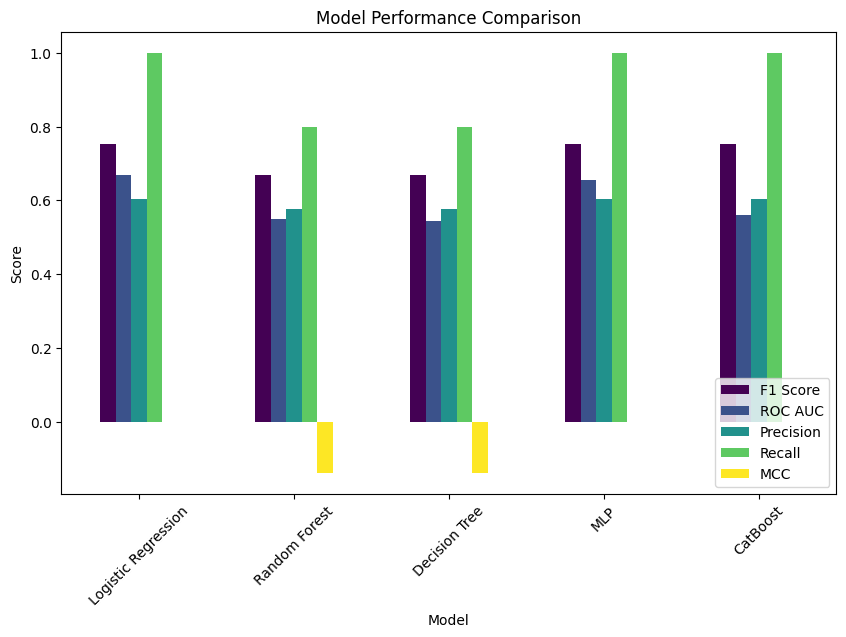

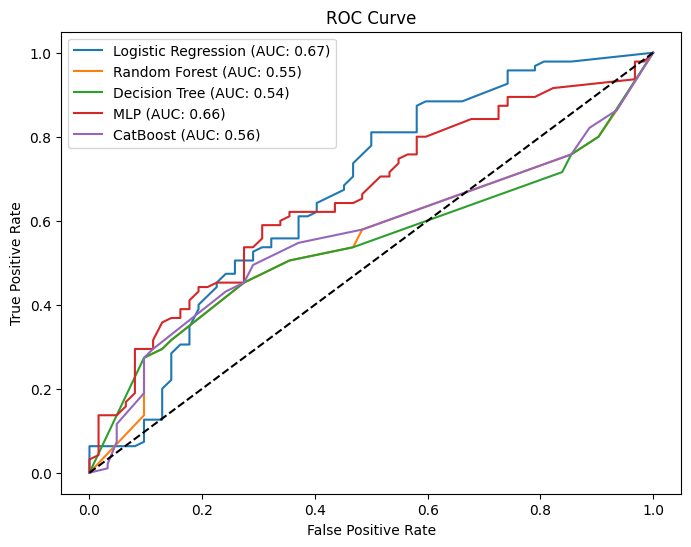

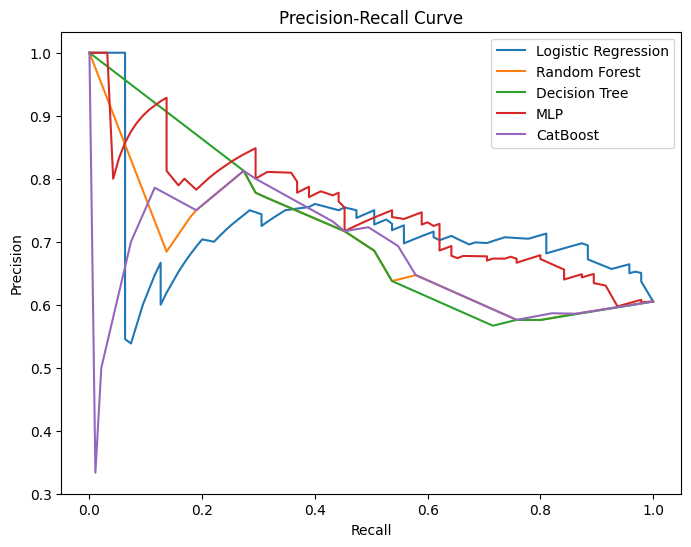

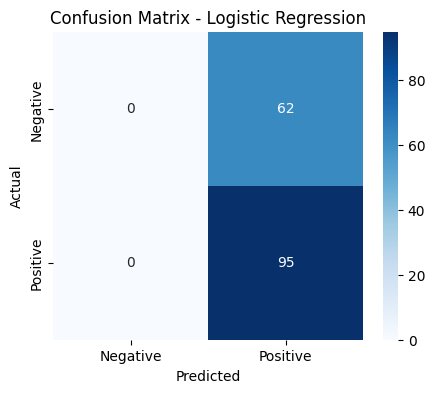

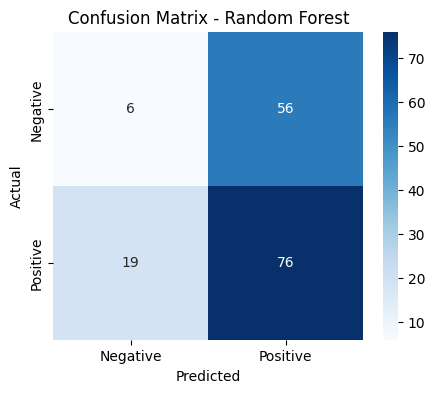

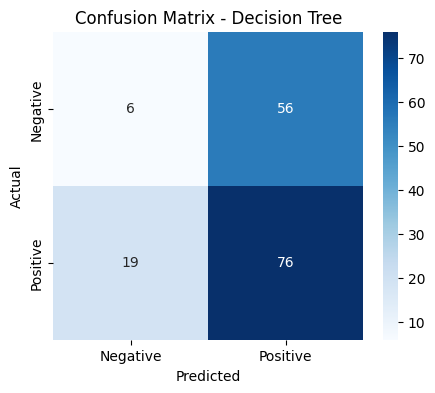

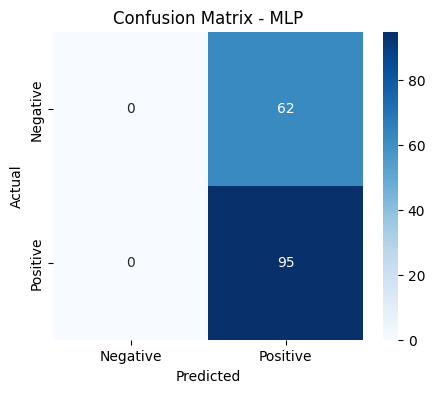

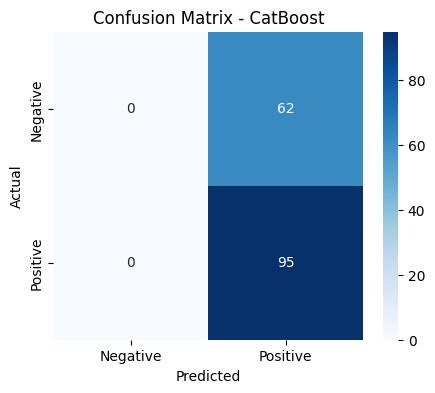

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

# Plot Model Performance Metrics
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for name, model in models:
    if name != 'FFNN':  # Skip FFNN if using different probability handling
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=f"{name} (AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
for name, model in models:
    if name != 'FFNN':
        precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix
for name, model in models:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# By checking the two best for classifiction algorithm we can see that Decision tree give better f1 score so we will choose that

In [33]:
cb = CatBoostClassifier(verbose=False, random_state=0)
cb.fit(X_train, y_train)

# 7. Evaluate the model
y_pred = cb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Decision Tree Model Performance:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Decision Tree Model Performance:
Accuracy: 0.5859872611464968
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.45      0.46        62
           1       0.65      0.67      0.66        95

    accuracy                           0.59       157
   macro avg       0.56      0.56      0.56       157
weighted avg       0.58      0.59      0.58       157



In [36]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=60)
dt.fit(X_train, y_train)

# 7. Evaluate the model
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


print("Decision Tree Model Performance:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Decision Tree Model Performance:
Accuracy: 0.5668789808917197
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.52      0.48        62
           1       0.66      0.60      0.63        95

    accuracy                           0.57       157
   macro avg       0.56      0.56      0.56       157
weighted avg       0.58      0.57      0.57       157



# Decision Tree Structure (Tree Diagram)

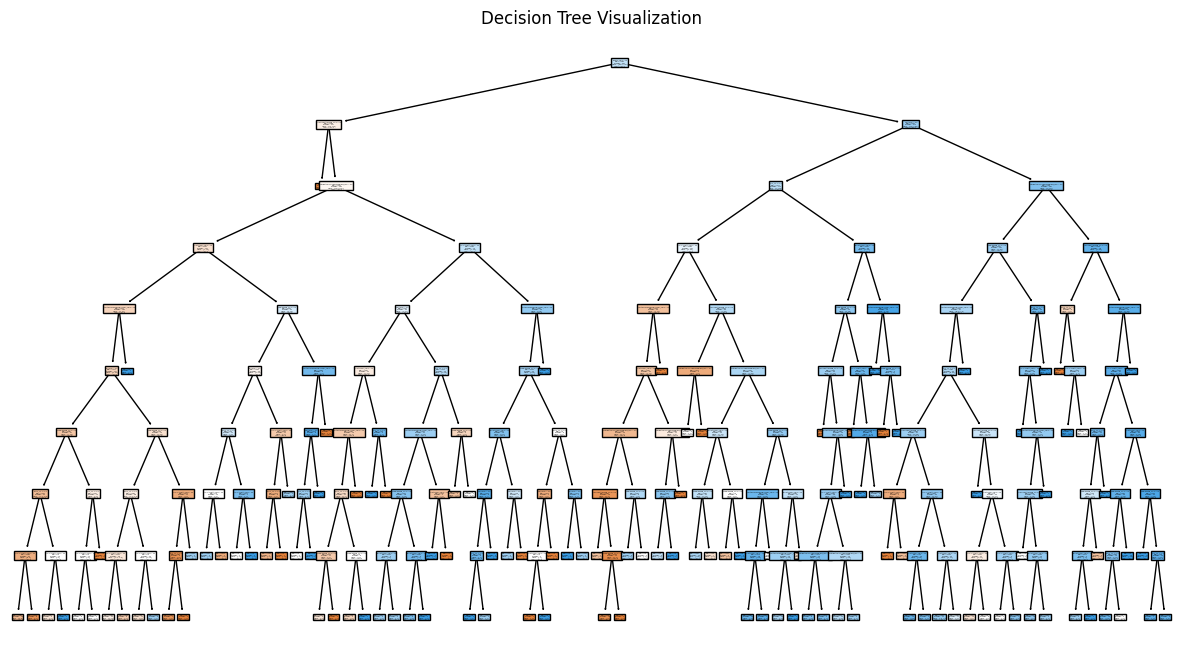

In [37]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
tree.plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=["Class 0", "Class 1"])
plt.title("Decision Tree Visualization")
plt.show()


# Feature Importance Bar Chart

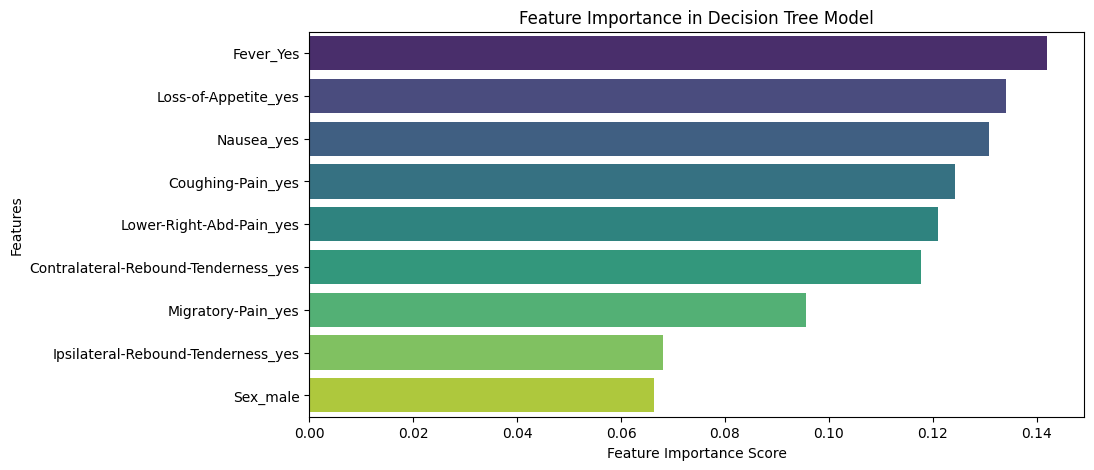

In [38]:
import seaborn as sns
import pandas as pd

# Get feature importance
feature_importance = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree Model")
plt.show()


# Confusion Matrix (Heatmap)